## Emotion Recognition

Create a CNN models for emotion recognition from facial image.

**Compare Model Architectures**
1. Block CNN: Using only Conv2D, Pooling Layers, Dense Layers, BatchNorm, LayerNorm, Activation Layers, Dropout
2. Resnet50
3. Resnet18
4. DenseNet
5. Sequential


### Import Libraries Needed 

In [1]:
# Import Libraries Needed 

import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torchvision.transforms import RandomHorizontalFlip, RandomRotation, RandomAffine, RandomPerspective, RandomResizedCrop, Compose

### Hyperparameter initializing

In [2]:
# Constants
RANDOM_STATE = 42
LEARNING_RATE = 0.0001
EPOCHS = 30
BATCH_SIZE = 32
NUM_CLASSES = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Set random seed
torch.manual_seed(RANDOM_STATE)

## Load and Preprocess Data

In [4]:
# Load data
data_path = "fer13_imagedataset.npy"
data = np.load(data_path, allow_pickle=True).item()

X_train, y_train = data['train']
X_val, y_val = data['val']
X_test, y_test = data['test']

In [5]:
# Convert string labels to integers
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [6]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)

y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [7]:
# Normalize data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [8]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

### Data Visualization

In [9]:
# Data Visualization
# 1. Count Subfolders and Image Count Distribution
emotions = np.array(['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral'])
train_path = r"C:/College/Semester 5/Computer Vision/Project/Mini Project/archive/train"

In [10]:
# Count images in each subfolder
emotion_counts = {}
for emotion in emotions:
    emotion_folder = os.path.join(train_path, emotion)
    if os.path.exists(emotion_folder):
        emotion_counts[emotion] = len(os.listdir(emotion_folder))

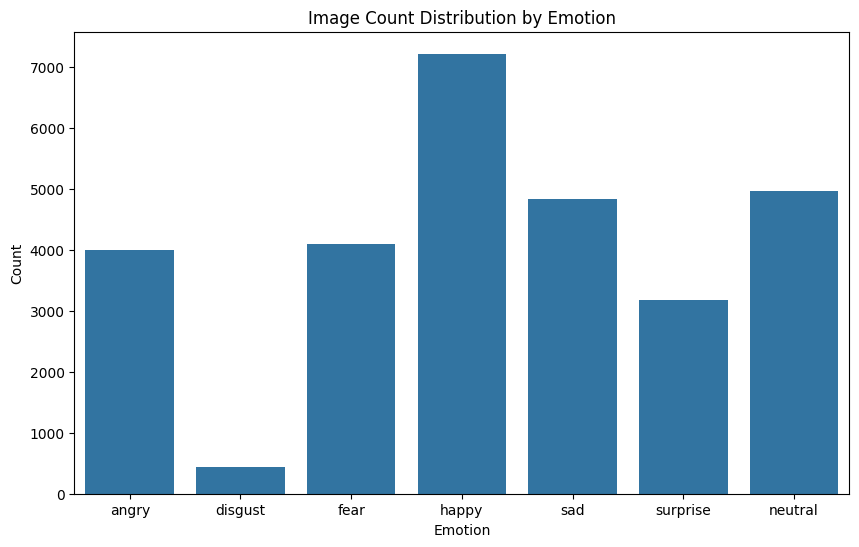

In [11]:
# Plot image count distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=list(emotion_counts.keys()), y=list(emotion_counts.values()))
plt.title("Image Count Distribution by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.show()

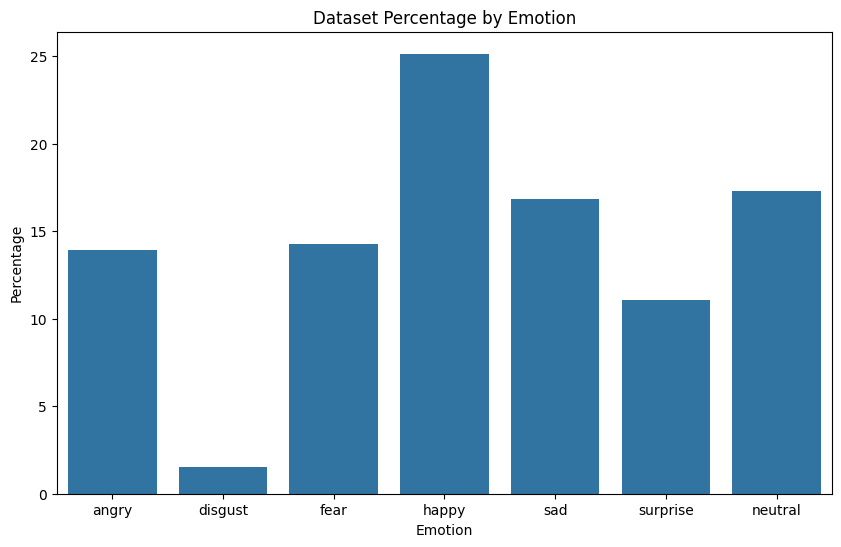

In [12]:
# 2. Dataset Percentage
total_images = sum(emotion_counts.values())
emotion_percentages = {emotion: (count / total_images) * 100 for emotion, count in emotion_counts.items()}

plt.figure(figsize=(10, 6))
sns.barplot(x=list(emotion_percentages.keys()), y=list(emotion_percentages.values()))
plt.title("Dataset Percentage by Emotion")
plt.xlabel("Emotion")
plt.ylabel("Percentage")
plt.show()

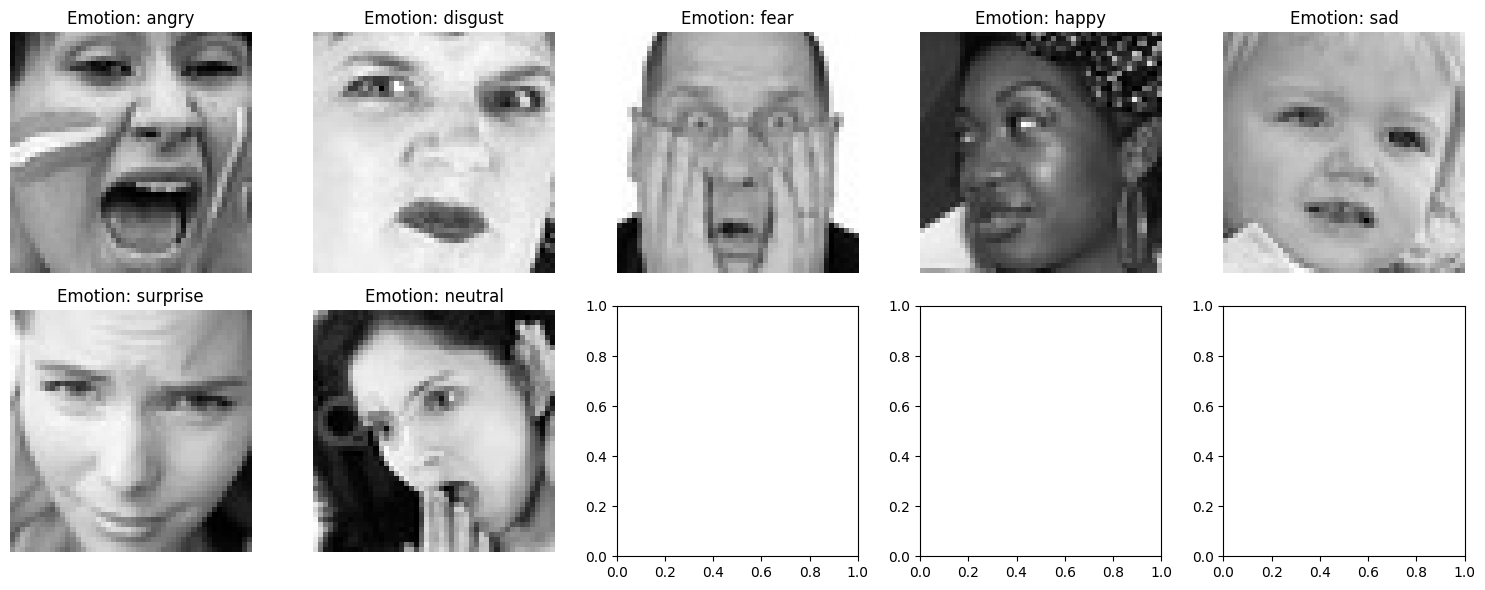

In [14]:
# 3. Display Sample Images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i, emotion in enumerate(emotions):
    sample_image = X_train[y_train == i][0].squeeze().cpu().numpy()
    axes[i // 5, i % 5].imshow(sample_image, cmap='gray')
    axes[i // 5, i % 5].set_title(f"Emotion: {emotion}")
    axes[i // 5, i % 5].axis('off')
plt.tight_layout()
plt.show()

### Data Augmentation

In [15]:
# 4. Data Augmentation Visualization
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomResizedCrop(size=(48, 48), scale=(0.8, 1.0))
])

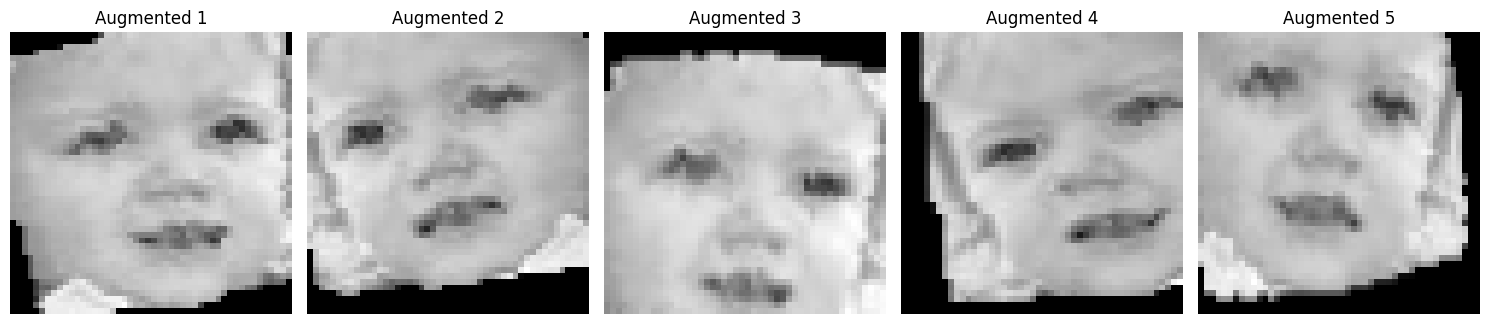

In [16]:
# Visualize augmented images
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
sample_image = X_train[0].unsqueeze(0)
for i in range(5):
    augmented_image = data_augmentation(sample_image).squeeze().cpu().numpy()
    axes[i].imshow(augmented_image, cmap='gray')
    axes[i].set_title(f"Augmented {i + 1}")
    axes[i].axis('off')
plt.tight_layout()
plt.show()

In [17]:
# Apply data augmentation to the dataset
augmented_images = []
augmented_labels = []
for image, label in zip(X_train, y_train):
    augmented_images.append(data_augmentation(image.unsqueeze(0)).squeeze(0))
    augmented_labels.append(label)
    if len(augmented_images) >= len(X_train):  # Double the dataset size
        break

X_train_augmented = torch.stack(augmented_images)
y_train_augmented = torch.stack(augmented_labels)

In [18]:
# Combine original and augmented data
X_train = torch.cat([X_train, X_train_augmented], dim=0)
y_train = torch.cat([y_train, y_train_augmented], dim=0)

### Block CNN Model Defining

In [40]:
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, Dropout, BatchNorm2d , Flatten, Softmax
from torch.optim import Adam
from torchsummary import summary

In [41]:
# create dataloader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE,)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE,)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE,)

In [42]:
class CNN(Module):
    def __init__(self, channels, num_classes):
        super().__init__()

        # Convolutional layers
        self.conv1 = Conv2d(in_channels=channels, out_channels=32, kernel_size=(5, 5), padding=2)
        self.conv2 = Conv2d(in_channels=32, out_channels=64, kernel_size=(5, 5), padding=2)
        self.conv3 = Conv2d(in_channels=64, out_channels=128, kernel_size=(5, 5), padding=2)
        self.conv4 = Conv2d(in_channels=128, out_channels=512, kernel_size=(5, 5), padding=2)
        self.conv5 = Conv2d(in_channels=512, out_channels=1024, kernel_size=(3, 3), padding=1)

        # Batch normalization
        self.batchnorm1 = BatchNorm2d(num_features=32)
        self.batchnorm2 = BatchNorm2d(num_features=64)
        self.batchnorm3 = BatchNorm2d(num_features=128)
        self.batchnorm4 = BatchNorm2d(num_features=512)
        self.batchnorm5 = BatchNorm2d(num_features=1024)

        # Other layers
        self.maxpool = MaxPool2d(kernel_size=(2, 2))
        self.relu = ReLU()
        self.dropout = Dropout(p=0.2)

        # Fully connected layers
        self.flatten = Flatten()
        self.fc1 = Linear(in_features=1024, out_features=512)
        self.fc2 = Linear(in_features=512, out_features=128)
        self.fc3 = Linear(in_features=128, out_features=num_classes)
        self.softmax = Softmax(dim=1)

    

    def forward(self, X):
        # block 1
        X = self.conv1(X)
        X = self.batchnorm1(X)
        X = self.relu(X)
        X = self.maxpool(X)

        # block 2
        X = self.conv2(X)
        X = self.batchnorm2(X)
        X = self.relu(X)
        X = self.maxpool(X)

        # block 3
        X = self.conv3(X)
        X = self.batchnorm3(X)
        X = self.relu(X)
        X = self.maxpool(X)

        # block 4
        X = self.conv4(X)
        X = self.batchnorm4(X)
        X = self.relu(X)
        X = self.maxpool(X)
        X = self.dropout(X)

        # block 5
        X = self.conv5(X)
        X = self.batchnorm5(X)
        X = self.relu(X)
        X = self.maxpool(X)
        X = self.dropout(X)

        
        # fully connected layer
        X = self.flatten(X)
        X = self.fc1(X)
        X = self.relu(X)
        X = self.dropout(X)

        X = self.fc2(X)
        X = self.relu(X)
        X = self.dropout(X)

        X = self.fc3(X)
        return X


In [43]:
model = CNN(channels = 1, num_classes = NUM_CLASSES).to(device)

In [44]:
optimizer = Adam(params = model.parameters(), lr = LEARNING_RATE)

In [45]:
# loss fn
loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float32).to(device))

NameError: name 'class_weights' is not defined

In [46]:
summary(model, (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             832
       BatchNorm2d-2           [-1, 32, 48, 48]              64
              ReLU-3           [-1, 32, 48, 48]               0
         MaxPool2d-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 64, 24, 24]          51,264
       BatchNorm2d-6           [-1, 64, 24, 24]             128
              ReLU-7           [-1, 64, 24, 24]               0
         MaxPool2d-8           [-1, 64, 12, 12]               0
            Conv2d-9          [-1, 128, 12, 12]         204,928
      BatchNorm2d-10          [-1, 128, 12, 12]             256
             ReLU-11          [-1, 128, 12, 12]               0
        MaxPool2d-12            [-1, 128, 6, 6]               0
           Conv2d-13            [-1, 512, 6, 6]       1,638,912
      BatchNorm2d-14            [-1, 51

In [47]:
# traning loop
def train_epoch(model, dataloader, loss_fn, optimizer):
  # turn on train phase
  model.train()
  running_loss = 0.0
  correct = 0
  total = 0

  for inputs, labels in dataloader:
    inputs, labels = inputs.to(device), labels.to(device)

    # forward pass
    outputs = model(inputs)

    # calculate loss
    loss = loss_fn(outputs, labels)

    # zero gradient
    optimizer.zero_grad()

    # backpropagation
    loss.backward()

    # update
    optimizer.step()

    # save loss and accuracy
    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  epoch_loss = running_loss / len(dataloader)
  epoch_acc = 100 * correct / total

  return epoch_loss, epoch_acc

In [48]:
# testing loop
def test_epoch(model, dataloader, loss_fn):
  # turn on test phase
  model.eval()
  correct = 0
  total = 0

  with torch.inference_mode():
    for inputs, labels in dataloader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  epoch_acc = 100 * correct / total

  return epoch_acc

In [49]:
import h5py  # Library untuk menyimpan model ke .h5

# Jumlah epoch diubah menjadi 30
EPOCHS = 30

# Inisialisasi variabel untuk menyimpan hasil training
best_acc = 0.0
train_loss_list = []
train_acc_list = []
val_acc_list = []

# Fungsi untuk menyimpan model ke .h5
def save_model_to_h5(model, file_path):
    with h5py.File(file_path, 'w') as f:
        for key, value in model.state_dict().items():
            f.create_dataset(key, data=value.cpu().numpy())

# Loop training untuk 30 epoch
for epoch in range(EPOCHS):
    # Training
    train_loss, train_acc = train_epoch(model, train_dataloader, loss_fn, optimizer)
    
    # Validation
    val_acc = test_epoch(model, val_dataloader, loss_fn)

    # Simpan hasil training dan validation
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)

    # Simpan model terbaik ke .h5
    if val_acc > best_acc:
        best_acc = val_acc
        save_model_to_h5(model, 'best_model.h5')  # Simpan ke .h5
        print(f"Best model saved to best_model.h5 at epoch {epoch + 1}")

    # Tampilkan hasil setiap epoch
    print(f"Epoch [{epoch + 1}/{EPOCHS}]")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Acc: {val_acc:.2f}%")
    print('-' * 50)

Best model saved to best_model.h5 at epoch 1
Epoch [1/30]
Train Loss: 1.5437 | Train Acc: 39.28%
Val Acc: 48.03%
--------------------------------------------------
Best model saved to best_model.h5 at epoch 2
Epoch [2/30]
Train Loss: 1.3169 | Train Acc: 49.83%
Val Acc: 52.87%
--------------------------------------------------
Best model saved to best_model.h5 at epoch 3
Epoch [3/30]
Train Loss: 1.1886 | Train Acc: 55.09%
Val Acc: 54.63%
--------------------------------------------------
Epoch [4/30]
Train Loss: 1.0759 | Train Acc: 59.54%
Val Acc: 54.51%
--------------------------------------------------
Epoch [5/30]
Train Loss: 0.9551 | Train Acc: 64.58%
Val Acc: 53.10%
--------------------------------------------------
Best model saved to best_model.h5 at epoch 6
Epoch [6/30]
Train Loss: 0.8391 | Train Acc: 69.30%
Val Acc: 55.78%
--------------------------------------------------
Epoch [7/30]
Train Loss: 0.7292 | Train Acc: 73.36%
Val Acc: 55.43%
--------------------------------------

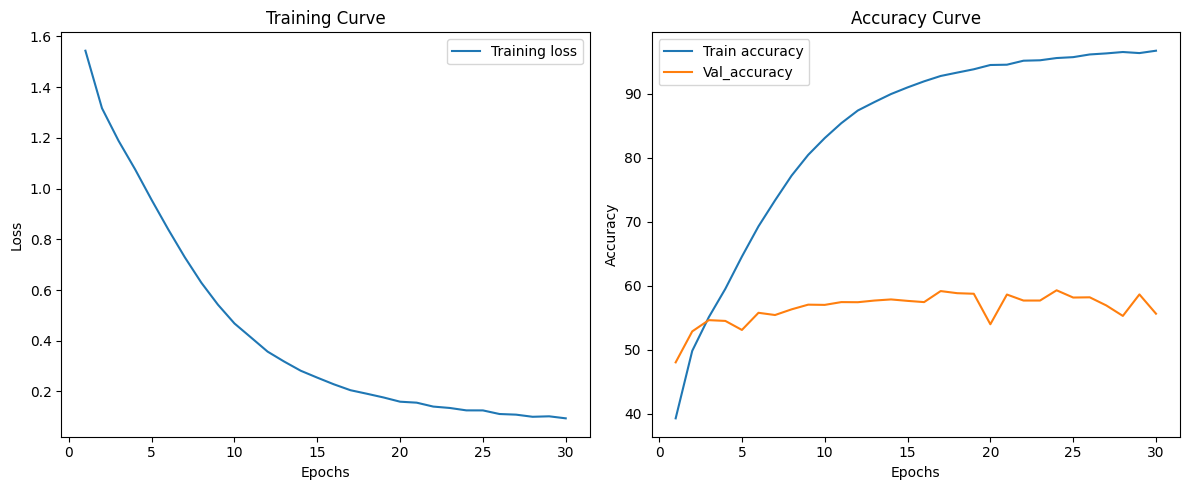

In [50]:
fig, axes = plt.subplots(ncols = 2, nrows = 1, figsize = (12, 5))

# Plot training curve
sns.lineplot(x = range(1, EPOCHS+1), y = train_loss_list, ax = axes[0], label = "Training loss")
axes[0].set_title("Training Curve")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")

# Plot accuracy curve
sns.lineplot(x = range(1, EPOCHS+1), y = train_acc_list, ax = axes[1], label = "Train accuracy")
sns.lineplot(x = range(1, EPOCHS+1), y = val_acc_list, ax = axes[1], label = "Val_accuracy")
axes[1].set_title("Accuracy Curve")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [51]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

In [52]:
y_pred = []
y_true = []

model.load_state_dict(torch.load('./best_model.pth'))
model.eval()

with torch.inference_mode():
  for inputs, labels in test_dataloader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = outputs.max(1)
    y_pred.extend(predicted.cpu().numpy())
    y_true.extend(labels.cpu().numpy())

  print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.53      0.46      0.49       958
           1       0.68      0.44      0.54       111
           2       0.55      0.31      0.40      1024
           3       0.80      0.76      0.78      1774
           4       0.50      0.59      0.54      1233
           5       0.43      0.53      0.48      1247
           6       0.66      0.80      0.72       831

    accuracy                           0.59      7178
   macro avg       0.59      0.56      0.56      7178
weighted avg       0.59      0.59      0.58      7178



In [53]:
print("F1 score macro:", f1_score(y_true, y_pred, average = 'macro'))

F1 score macro: 0.5638751969898735


In [54]:
print("Accuracy:", accuracy_score(y_true, y_pred))

Accuracy: 0.58790749512399


In [55]:
f1_scores = f1_score(y_true, y_pred, average=None)

f1_data = pd.DataFrame({
    'Emotion': emotions,
    'F1-Score': f1_scores
})

NameError: name 'emotion_count' is not defined

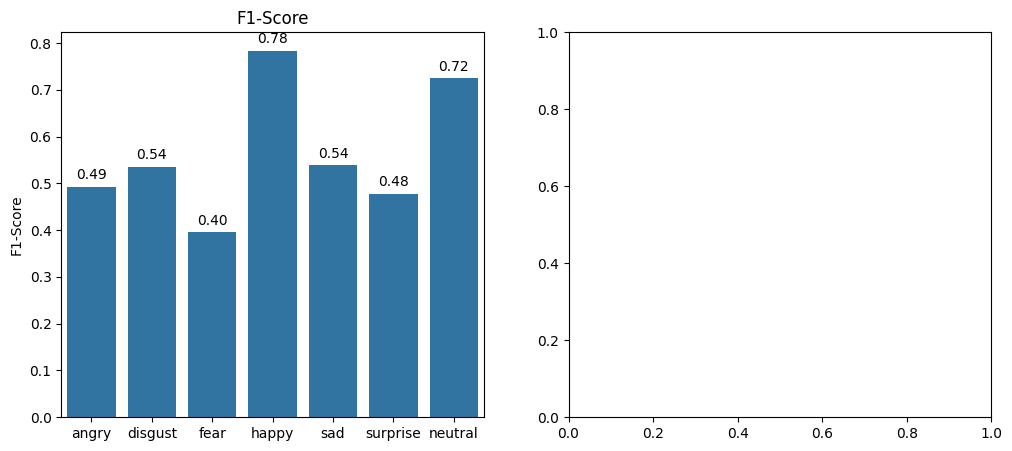

In [56]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

#----F1 SCORE PLOT-------
sns.barplot(x='Emotion', y='F1-Score', data=f1_data, ax=axes[0])
axes[0].set_title("F1-Score")
axes[0].set_xlabel("")
axes[0].set_ylabel("F1-Score")

for i, bar in enumerate(axes[0].containers[0]):  # containers[0] contain bars
    value = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, value + 0.01,  # label position
                 f"{value:.2f}", ha='center', va='bottom', fontsize=10)


#----COUNTPLOT-------
sns.barplot(y=emotion_count, x=emotions, ax=axes[1])
axes[1].set_title("Count")
axes[1].set_xlabel("")
axes[1].set_ylabel("Count")

for i, bar in enumerate(axes[1].containers[0]):
    value = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, value + 1,
                 f"{int(value)}", ha='center', va='bottom', fontsize=10)


plt.tight_layout()
plt.show()

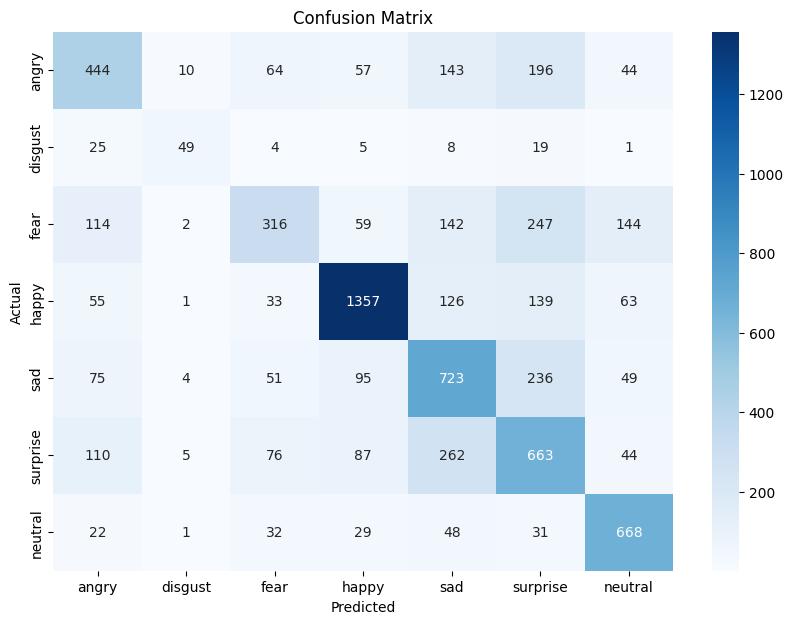

In [57]:
# confusion matrix heatmap
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.show()

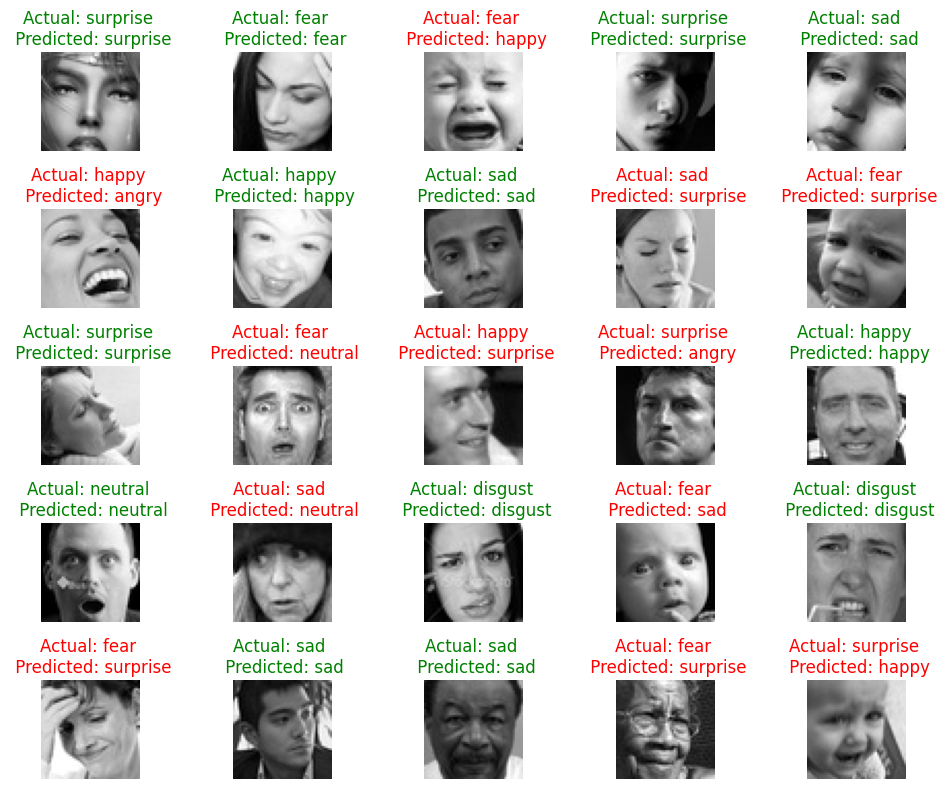

In [58]:
# show 25 random test image and model predictions of them
fig, axes = plt.subplots(ncols = 5, nrows = 5, figsize = (10, 8))
axes = axes.flatten()

for i in range(25):
  idx = np.random.randint(0, len(X_test))
  image = X_test[idx]
  label = y_test[idx]
  pred = y_pred[idx]

  if label == pred:
    title_color = 'green'
  else:
    title_color = 'red'
  
  axes[i].imshow(image.squeeze().cpu().numpy(), cmap = 'gray')
  axes[i].set_title(f"Actual: {emotions[label]} \n Predicted: {emotions[pred]}", color = title_color)
  axes[i].axis('off')

plt.tight_layout()
plt.show()

### Compares Model Defining (Block CNN, Resnet50, Resnet18, DenseNet)

In [59]:
# Update DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [71]:
# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [72]:
# CNN Model
class CNN(nn.Module):
    def __init__(self, channels, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(128, 512, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.maxpool(self.relu(self.conv3(x)))
        x = self.maxpool(self.relu(self.conv4(x)))
        x = self.maxpool(self.relu(self.conv5(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# ResNet50
resnet50 = models.resnet50(pretrained=True)
resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet50.fc = nn.Linear(resnet50.fc.in_features, NUM_CLASSES)

# ResNet18
resnet18 = models.resnet18(pretrained=True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, NUM_CLASSES)

# DenseNet
densenet = models.densenet121(pretrained=True)
densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
densenet.classifier = nn.Linear(densenet.classifier.in_features, NUM_CLASSES)


# Dictionary of models
models_dict = {
    "CNN": CNN(1, NUM_CLASSES).to(device),
    "ResNet50": resnet50.to(device),
    "ResNet18": resnet18.to(device),
    "DenseNet": densenet.to(device),
}

C:\Users\abdur\anaconda3\envs\cv_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\abdur\anaconda3\envs\cv_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\abdur\anaconda3\envs\cv_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Wei

In [73]:
model = CNN(channels = 1, num_classes = NUM_CLASSES).to(device)

In [74]:
optimizer = Adam(params = model.parameters(), lr = LEARNING_RATE)

In [75]:
summary(model, (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             832
              ReLU-2           [-1, 32, 48, 48]               0
         MaxPool2d-3           [-1, 32, 24, 24]               0
            Conv2d-4           [-1, 64, 24, 24]          51,264
              ReLU-5           [-1, 64, 24, 24]               0
         MaxPool2d-6           [-1, 64, 12, 12]               0
            Conv2d-7          [-1, 128, 12, 12]         204,928
              ReLU-8          [-1, 128, 12, 12]               0
         MaxPool2d-9            [-1, 128, 6, 6]               0
           Conv2d-10            [-1, 512, 6, 6]       1,638,912
             ReLU-11            [-1, 512, 6, 6]               0
        MaxPool2d-12            [-1, 512, 3, 3]               0
           Conv2d-13           [-1, 1024, 3, 3]       4,719,616
             ReLU-14           [-1, 102

### Training and Evaluation Functions

In [76]:
# Training and Evaluation Functions
def train_epoch(model, dataloader, loss_fn, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


In [77]:
def test_epoch(model, dataloader, loss_fn):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_acc = 100 * correct / total
    return epoch_acc

In [78]:
# Save model to .h5
def save_model_to_h5(model, file_path):
    with h5py.File(file_path, 'w') as f:
        for key, value in model.state_dict().items():
            f.create_dataset(key, data=value.cpu().numpy())

In [79]:
# Train and Evaluate Each Model
for model_name, model in models_dict.items():
    print(f"Training {model_name}...")
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()

    train_loss_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_dataloader, loss_fn, optimizer)
        val_acc = test_epoch(model, val_dataloader, loss_fn)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        print(f"Epoch [{epoch + 1}/{EPOCHS}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # Save model as .h5
    save_model_to_h5(model, f"{model_name}.h5")
    print(f"{model_name} saved as {model_name}.h5")

Training CNN...
Epoch [1/30] - Train Loss: 1.8092, Train Acc: 24.69%, Val Acc: 28.06%
Epoch [2/30] - Train Loss: 1.6489, Train Acc: 33.57%, Val Acc: 42.22%
Epoch [3/30] - Train Loss: 1.4655, Train Acc: 42.64%, Val Acc: 46.59%
Epoch [4/30] - Train Loss: 1.3480, Train Acc: 48.07%, Val Acc: 51.34%
Epoch [5/30] - Train Loss: 1.2419, Train Acc: 52.87%, Val Acc: 53.03%
Epoch [6/30] - Train Loss: 1.1395, Train Acc: 57.14%, Val Acc: 55.03%
Epoch [7/30] - Train Loss: 1.0283, Train Acc: 61.62%, Val Acc: 55.80%
Epoch [8/30] - Train Loss: 0.9014, Train Acc: 66.70%, Val Acc: 56.51%
Epoch [9/30] - Train Loss: 0.7580, Train Acc: 72.29%, Val Acc: 56.91%
Epoch [10/30] - Train Loss: 0.6053, Train Acc: 78.32%, Val Acc: 57.30%
Epoch [11/30] - Train Loss: 0.4660, Train Acc: 83.52%, Val Acc: 57.40%
Epoch [12/30] - Train Loss: 0.3450, Train Acc: 88.09%, Val Acc: 58.45%
Epoch [13/30] - Train Loss: 0.2596, Train Acc: 91.11%, Val Acc: 56.84%
Epoch [14/30] - Train Loss: 0.2017, Train Acc: 93.16%, Val Acc: 57.78%

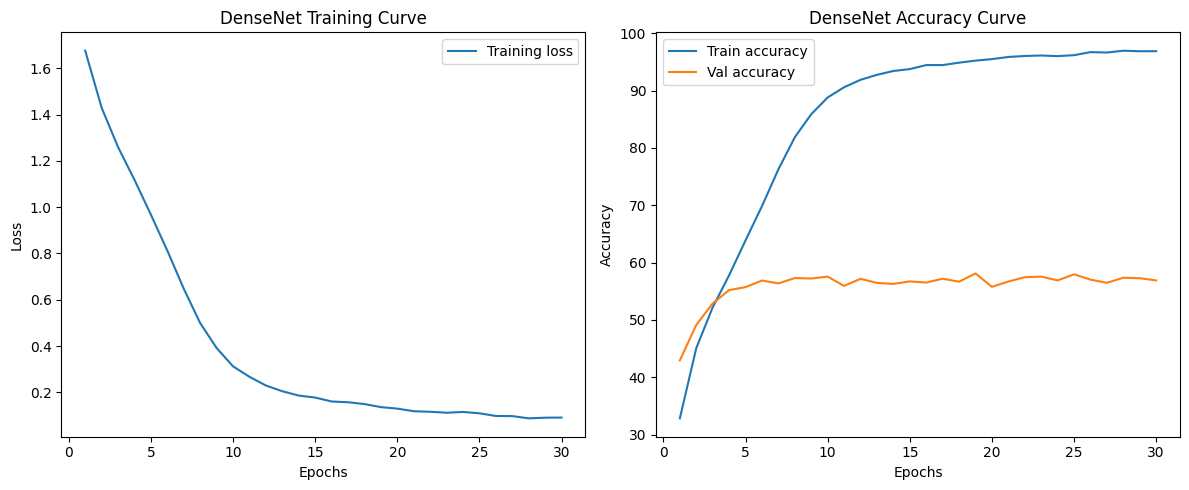

In [80]:
# Plot Training and Accuracy Curves
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
sns.lineplot(x=range(1, EPOCHS + 1), y=train_loss_list, ax=axes[0], label="Training loss")
axes[0].set_title(f"{model_name} Training Curve")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")

sns.lineplot(x=range(1, EPOCHS + 1), y=train_acc_list, ax=axes[1], label="Train accuracy")
sns.lineplot(x=range(1, EPOCHS + 1), y=val_acc_list, ax=axes[1], label="Val accuracy")
axes[1].set_title(f"{model_name} Accuracy Curve")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [81]:
# Evaluate Model
y_pred = []
y_true = []

model.load_state_dict(torch.load(f"{model_name}.h5"))
model.eval()

with torch.no_grad():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Classification Report
print(f"Classification Report for {model_name}:")
print(classification_report(y_true, y_pred, target_names=emotions))

# F1 Score and Accuracy
print(f"F1 Score (Macro) for {model_name}: {f1_score(y_true, y_pred, average='macro'):.4f}")
print(f"Accuracy for {model_name}: {accuracy_score(y_true, y_pred):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

UnpicklingError: Weights only load failed. In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
Please file an issue with the following so that we can make `weights_only=True` compatible with your use case: WeightsUnpickler error: Unsupported operand 72

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

IndexError: list index out of range

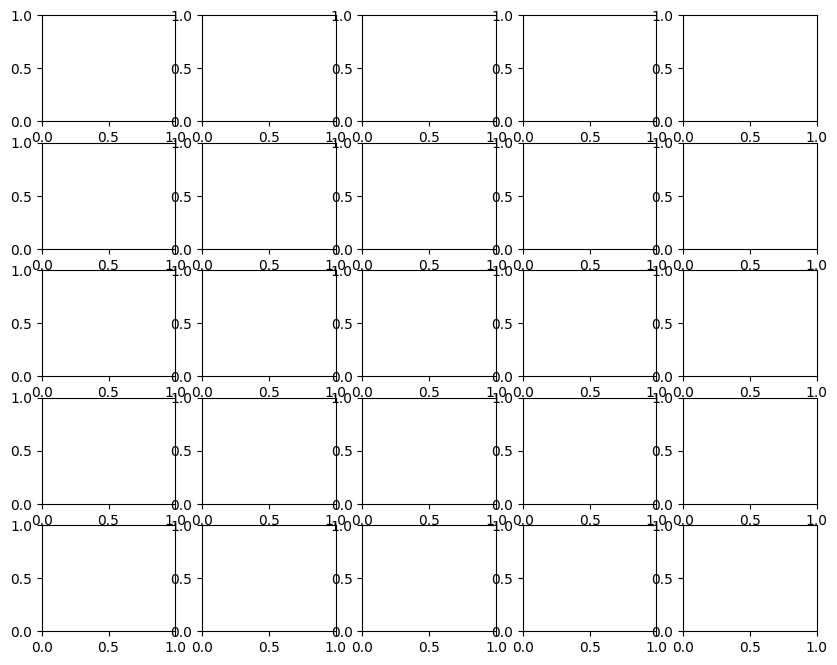

In [82]:
# Show 25 Random Test Images with Predictions
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(10, 8))
axes = axes.flatten()

for i in range(25):
    idx = np.random.randint(0, len(X_test))
    image = X_test[idx].squeeze().cpu().numpy()
    label = y_test[idx].cpu().numpy()
    pred = y_pred[idx]

    if label == pred:
        title_color = 'green'
    else:
        title_color = 'red'

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Actual: {emotions[label]}\nPredicted: {emotions[pred]}", color=title_color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [66]:
models_dict = {
    "CNN": CNN(1, NUM_CLASSES).to(device),
    "ResNet50": resnet50.to(device),
    "ResNet18": resnet18.to(device),
    "DenseNet": densenet.to(device),
}

for model_name, model in models_dict.items():
    print(f"Training {model_name}...")
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()

    train_loss_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_dataloader, loss_fn, optimizer)
        val_acc = test_epoch(model, val_dataloader, loss_fn)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # Save model as .h5
    torch.save(model.state_dict(), f"{model_name}.h5")
    print(f"{model_name} saved as {model_name}.h5")

Training CNN...
Epoch [1/30] - Train Loss: 1.8024, Train Acc: 25.16%, Val Acc: 30.90%
Epoch [2/30] - Train Loss: 1.6077, Train Acc: 36.02%, Val Acc: 43.38%
Epoch [3/30] - Train Loss: 1.4384, Train Acc: 44.03%, Val Acc: 47.75%
Epoch [4/30] - Train Loss: 1.3250, Train Acc: 48.83%, Val Acc: 51.72%
Epoch [5/30] - Train Loss: 1.2247, Train Acc: 53.39%, Val Acc: 54.53%
Epoch [6/30] - Train Loss: 1.1205, Train Acc: 57.74%, Val Acc: 55.09%
Epoch [7/30] - Train Loss: 0.9972, Train Acc: 62.93%, Val Acc: 56.03%
Epoch [8/30] - Train Loss: 0.8612, Train Acc: 68.02%, Val Acc: 57.94%
Epoch [9/30] - Train Loss: 0.7119, Train Acc: 74.16%, Val Acc: 58.29%
Epoch [10/30] - Train Loss: 0.5589, Train Acc: 80.00%, Val Acc: 56.91%
Epoch [11/30] - Train Loss: 0.4162, Train Acc: 85.29%, Val Acc: 58.73%
Epoch [12/30] - Train Loss: 0.3037, Train Acc: 89.44%, Val Acc: 57.87%
Epoch [13/30] - Train Loss: 0.2334, Train Acc: 91.82%, Val Acc: 57.42%
Epoch [14/30] - Train Loss: 0.1806, Train Acc: 93.92%, Val Acc: 58.03%

RuntimeError: Given input size: (256x2x2). Calculated output size: (256x0x0). Output size is too small

KeyError: 'y'

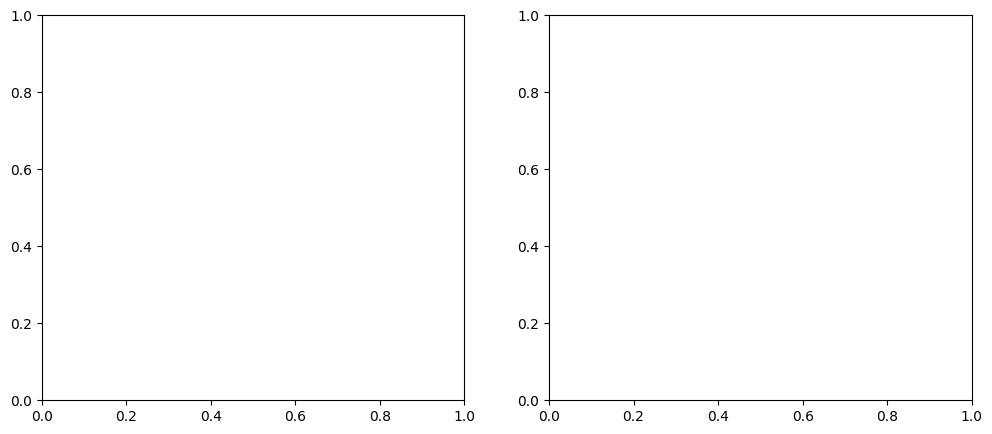

In [70]:
# Plot Training and Accuracy Curves
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
sns.lineplot(x=range(1, EPOCHS + 1), y=train_loss_list, ax=axes[0], label="Training loss")
axes[0].set_title(f"{model_name} Training Curve")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")

sns.lineplot(x=range(1, EPOCHS + 1), y=train_acc_list, ax=axes[1], label="Train accuracy")
sns.lineplot(x=range(1, EPOCHS + 1), y=val_acc_list, ax=axes[1], label="Val accuracy")
axes[1].set_title(f"{model_name} Accuracy Curve")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

KeyError: 'y'

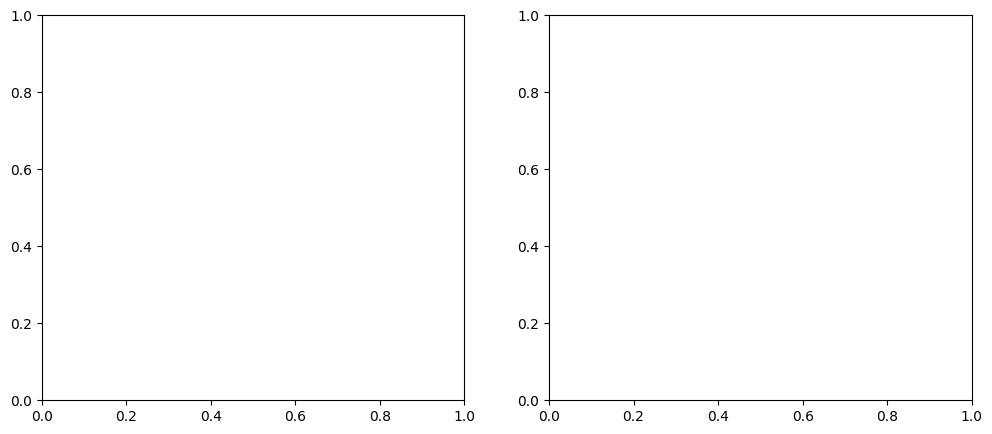

In [69]:
# 1. Plot Training and Accuracy Curves
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

# Plot training curve
sns.lineplot(x=range(1, EPOCHS + 1), y=train_loss_list, ax=axes[0], label="Training loss")
axes[0].set_title("Training Curve")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")

# Plot accuracy curve
sns.lineplot(x=range(1, EPOCHS + 1), y=train_acc_list, ax=axes[1], label="Train accuracy")
sns.lineplot(x=range(1, EPOCHS + 1), y=val_acc_list, ax=axes[1], label="Val accuracy")
axes[1].set_title("Accuracy Curve")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()

In [ ]:
# 2. Evaluate Model
y_pred = []
y_true = []

model.load_state_dict(torch.load('./best_model.h5'))  # Load model dari .h5
model.eval()

with torch.inference_mode():
    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Classification Report
print(classification_report(y_true, y_pred, target_names=emotions))

# F1 Score and Accuracy
print("F1 Score (Macro):", f1_score(y_true, y_pred, average='macro'))
print("Accuracy:", accuracy_score(y_true, y_pred))

# 3. F1-Score and Count Plot
f1_scores = f1_score(y_true, y_pred, average=None)
f1_data = pd.DataFrame({
    'Emotion': emotions,
    'F1-Score': f1_scores
})

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

# F1-Score Plot
sns.barplot(x='Emotion', y='F1-Score', data=f1_data, ax=axes[0])
axes[0].set_title("F1-Score")
axes[0].set_xlabel("")
axes[0].set_ylabel("F1-Score")

for i, bar in enumerate(axes[0].containers[0]):
    value = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width() / 2, value + 0.01,
                 f"{value:.2f}", ha='center', va='bottom', fontsize=10)

# Count Plot
sns.barplot(y=emotion_count, x=emotions, ax=axes[1])
axes[1].set_title("Count")
axes[1].set_xlabel("")
axes[1].set_ylabel("Count")

for i, bar in enumerate(axes[1].containers[0]):
    value = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width() / 2, value + 1,
                 f"{int(value)}", ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# 4. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 5. Show 25 Random Test Images with Predictions
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(10, 8))
axes = axes.flatten()

for i in range(25):
    idx = np.random.randint(0, len(X_test))
    image = X_test[idx].squeeze().cpu().numpy()
    label = y_test[idx].cpu().numpy()
    pred = y_pred[idx]

    if label == pred:
        title_color = 'green'
    else:
        title_color = 'red'

    axes[i].imshow(image, cmap='gray')
    axes[i].set_title(f"Actual: {emotions[label]}\nPredicted: {emotions[pred]}", color=title_color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Update DataLoader
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [36]:
# Custom CNN Model
class CNN(nn.Module):
    def __init__(self, channels, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(128, 512, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.maxpool(self.relu(self.conv1(x)))
        x = self.maxpool(self.relu(self.conv2(x)))
        x = self.maxpool(self.relu(self.conv3(x)))
        x = self.maxpool(self.relu(self.conv4(x)))
        x = self.maxpool(self.relu(self.conv5(x)))
        x = self.flatten(x)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

# ResNet50
resnet50 = models.resnet50(pretrained=True)
resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet50.fc = nn.Linear(resnet50.fc.in_features, NUM_CLASSES)

# ResNet18
resnet18 = models.resnet18(pretrained=True)
resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet18.fc = nn.Linear(resnet18.fc.in_features, NUM_CLASSES)

# DenseNet
densenet = models.densenet121(pretrained=True)
densenet.features.conv0 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
densenet.classifier = nn.Linear(densenet.classifier.in_features, NUM_CLASSES)

# Sequential Model
sequential_model = nn.Sequential(
    nn.Conv2d(1, 32, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32, 64, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(64 * 12 * 12, 128),
    nn.ReLU(),
    nn.Linear(128, NUM_CLASSES)
)

C:\Users\abdur\anaconda3\envs\cv_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\abdur\anaconda3\envs\cv_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\abdur\anaconda3\envs\cv_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Wei

In [37]:
model = CNN(channels = 1, num_classes = NUM_CLASSES).to(device)

In [38]:
optimizer = Adam(params = model.parameters(), lr = LEARNING_RATE)

In [39]:
summary(model, (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             832
              ReLU-2           [-1, 32, 48, 48]               0
         MaxPool2d-3           [-1, 32, 24, 24]               0
            Conv2d-4           [-1, 64, 24, 24]          51,264
              ReLU-5           [-1, 64, 24, 24]               0
         MaxPool2d-6           [-1, 64, 12, 12]               0
            Conv2d-7          [-1, 128, 12, 12]         204,928
              ReLU-8          [-1, 128, 12, 12]               0
         MaxPool2d-9            [-1, 128, 6, 6]               0
           Conv2d-10            [-1, 512, 6, 6]       1,638,912
             ReLU-11            [-1, 512, 6, 6]               0
        MaxPool2d-12            [-1, 512, 3, 3]               0
           Conv2d-13           [-1, 1024, 3, 3]       4,719,616
             ReLU-14           [-1, 102

In [21]:
def train_epoch(model, dataloader, loss_fn, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [22]:
def test_epoch(model, dataloader, loss_fn):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    epoch_acc = 100 * correct / total
    return epoch_acc

In [23]:
models_dict = {
    "CNN": CNN(1, NUM_CLASSES).to(device),
    "ResNet50": resnet50.to(device),
    "ResNet18": resnet18.to(device),
    "DenseNet": densenet.to(device),
    "AlexNet": alexnet.to(device),
    "VGGNet": vggnet.to(device),
    "Sequential": sequential_model.to(device)
}

for model_name, model in models_dict.items():
    print(f"Training {model_name}...")
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    loss_fn = nn.CrossEntropyLoss()

    train_loss_list = []
    train_acc_list = []
    val_acc_list = []

    for epoch in range(EPOCHS):
        train_loss, train_acc = train_epoch(model, train_dataloader, loss_fn, optimizer)
        val_acc = test_epoch(model, val_dataloader, loss_fn)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        print(f"Epoch [{epoch+1}/{EPOCHS}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    # Save model as .h5
    torch.save(model.state_dict(), f"{model_name}.h5")
    print(f"{model_name} saved as {model_name}.h5")

Training CNN...
Epoch [1/30] - Train Loss: 1.8122, Train Acc: 24.53%, Val Acc: 27.90%
Epoch [2/30] - Train Loss: 1.6443, Train Acc: 34.30%, Val Acc: 41.90%
Epoch [3/30] - Train Loss: 1.4701, Train Acc: 42.42%, Val Acc: 46.12%
Epoch [4/30] - Train Loss: 1.3622, Train Acc: 47.23%, Val Acc: 49.77%
Epoch [5/30] - Train Loss: 1.2642, Train Acc: 51.51%, Val Acc: 50.47%
Epoch [6/30] - Train Loss: 1.1643, Train Acc: 55.62%, Val Acc: 54.35%
Epoch [7/30] - Train Loss: 1.0525, Train Acc: 60.41%, Val Acc: 55.59%
Epoch [8/30] - Train Loss: 0.9217, Train Acc: 65.61%, Val Acc: 55.90%
Epoch [9/30] - Train Loss: 0.7767, Train Acc: 71.49%, Val Acc: 56.39%
Epoch [10/30] - Train Loss: 0.6258, Train Acc: 77.28%, Val Acc: 55.99%
Epoch [11/30] - Train Loss: 0.4797, Train Acc: 82.89%, Val Acc: 56.22%
Epoch [12/30] - Train Loss: 0.3526, Train Acc: 87.72%, Val Acc: 56.30%
Epoch [13/30] - Train Loss: 0.2639, Train Acc: 90.80%, Val Acc: 57.07%
Epoch [14/30] - Train Loss: 0.2005, Train Acc: 93.10%, Val Acc: 57.80%

RuntimeError: Given input size: (256x2x2). Calculated output size: (256x0x0). Output size is too small

In [24]:
for model_name, model in models_dict.items():
    print(f"Evaluating {model_name}...")
    model.load_state_dict(torch.load(f"{model_name}.h5"))
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
    print(classification_report(y_true, y_pred))
    print(f"F1 Score (Macro): {f1_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

Evaluating CNN...
              precision    recall  f1-score   support

           0       0.49      0.44      0.47       958
           1       0.75      0.41      0.53       111
           2       0.41      0.43      0.42      1024
           3       0.74      0.83      0.78      1774
           4       0.52      0.50      0.51      1233
           5       0.44      0.45      0.45      1247
           6       0.79      0.68      0.73       831

    accuracy                           0.58      7178
   macro avg       0.59      0.54      0.56      7178
weighted avg       0.58      0.58      0.57      7178

F1 Score (Macro): 0.5555
Accuracy: 0.5759
Evaluating ResNet50...
              precision    recall  f1-score   support

           0       0.46      0.47      0.47       958
           1       0.60      0.47      0.53       111
           2       0.47      0.42      0.45      1024
           3       0.75      0.79      0.77      1774
           4       0.48      0.55      0.51      

FileNotFoundError: [Errno 2] No such file or directory: 'AlexNet.h5'